In [45]:
import os, re
import pickle
import numpy as np
import pandas as pd

import joblib

#matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

import matplotlib.colors as mc
from mpl_toolkits.axes_grid1 import make_axes_locatable

#scipy
from scipy import ndimage
from scipy.stats import gaussian_kde

from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

import rioxarray
import xarray
import rasterio
import xarray as xr

## GDAL
from osgeo import gdal, osr, ogr

## WQ_SAT
from wq_sat import config
from wq_sat.satellites import sentinel2
from wq_sat.bathymetry import SDB
from wq_sat.utils import geo_utils, plot_utils, data_utils

In [2]:
region = 'CalaMillor'
year = '2020'
save_plots = True
main_path = os.path.join(config.data_path(), 'bathymetries', region, year)

## In-situ bathymetry

Num of bands: 1
Shape: (190, 80)
CRS: EPSG:32631
{'N': 39.603706288152, 'W': 3.3843306531157413, 'S': 39.58664616930425, 'E': 3.393436068278689}


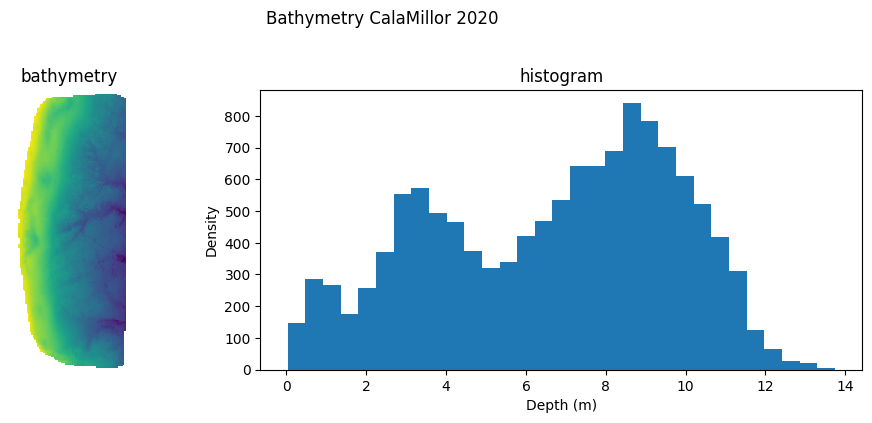

In [3]:
## In-situ bathymetry
file = '{}_Insitu_bathymetry_EPSG32631_{}.tif'.format(region, year)
bathymetry, BBox, crs = geo_utils.load_geotiff(os.path.join(main_path, file))
# bathymetry[bathymetry < -5] = np.nan
mx = np.ma.masked_invalid(bathymetry)

## transform coordinates
new_ul = geo_utils.transform_coordinates(BBox[0], inputEPSG=crs, outputEPSG=4326)
new_lr = geo_utils.transform_coordinates(BBox[1], inputEPSG=crs, outputEPSG=4326)

# ROI
roi_coord = {'N': new_ul[0], 'W': new_ul[1], 'S': new_lr[0], 'E': new_lr[1]}
print(roi_coord)

# plot it
fig=plt.figure(figsize=(12,8))

ax1 = plt.subplot2grid((2,3),(0,0))
ax1.imshow(bathymetry)
ax1.set_title('bathymetry')
ax1.axis('off')

ax2 = plt.subplot2grid((2,3),(0,1), colspan=3)
ax2.hist((-bathymetry).flatten(), bins='auto')
ax2.set_title('histogram')
ax2.set_xlabel('Depth (m)')
ax2.set_ylabel('Density')

fig.suptitle('Bathymetry {} {}'.format(region, year))
plt.show()

## ML Composite Approach

In [4]:
tiles = config.get_tiles(region, year)
Zgr_max, Zr_max, Rs492, Rs559, Rs704, chl, coord = SDB.ML_WQproxies(tiles, roi_coord)

Zgr_max[mx.mask] = np.nan
Zr_max[mx.mask] = np.nan
Rs492[mx.mask] = np.nan
Rs559[mx.mask] = np.nan
Rs704[mx.mask] = np.nan
chl[mx.mask] = np.nan

Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20200924T104031_N0209_R008_T31SED_20200924T143955
Selected pixel region: xmin=3301, ymin=1619, xmax=3380, ymax=1808:
Image size: width=80 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20200924T104031_N0209_R008_T31SED_20200924T143955
Selected pixel region: xmin=3301, ymin=1619, xmax=3380, ymax=1808:
Image size: width=80 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2B_MSIL1C_20201006T102819_N0209_R108_T31SED_20201006T124559
Selected pixel region: xmin=3301, ymin=1619, xmax=3380, ymax=1808:
Image size: width=80 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2B_MSIL1C_20200919T103649_N0209_R008_T31SED_20200919T125309
Selected pixel region: xmin=3301, ymin=1619, xmax=3380, ymax=1808:
Image size: width=80 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2B_MSIL1C_20200916T102649_N0209_R108_T31SED_20200916T124334
Selected pixel region: xmin=3301, ymin=1619, xmax=3380, ymax=1808:
Imag

/home/wq_sat/wq_sat/bathymetry/SDB.py:50: RuntimeWarning: All-NaN slice encountered
  Zgr_max = np.nanmax(Zgreen, axis=2)
/home/wq_sat/wq_sat/bathymetry/SDB.py:51: RuntimeWarning: All-NaN slice encountered
  Zr_max = np.nanmax(Zred, axis=2)
/home/wq_sat/wq_sat/bathymetry/SDB.py:52: RuntimeWarning: All-NaN slice encountered
  Rs492_max = np.nanmax(Rs492, axis=2)
/home/wq_sat/wq_sat/bathymetry/SDB.py:53: RuntimeWarning: All-NaN slice encountered
  Rs559_max = np.nanmax(Rs559, axis=2)
/home/wq_sat/wq_sat/bathymetry/SDB.py:54: RuntimeWarning: All-NaN slice encountered
  Rs704_max = np.nanmax(Rs704, axis=2)
/home/wq_sat/wq_sat/bathymetry/SDB.py:55: RuntimeWarning: All-NaN slice encountered
  chl_max = np.nanmax(chl, axis=2)


Text(0.5, 1.0, 'chl')

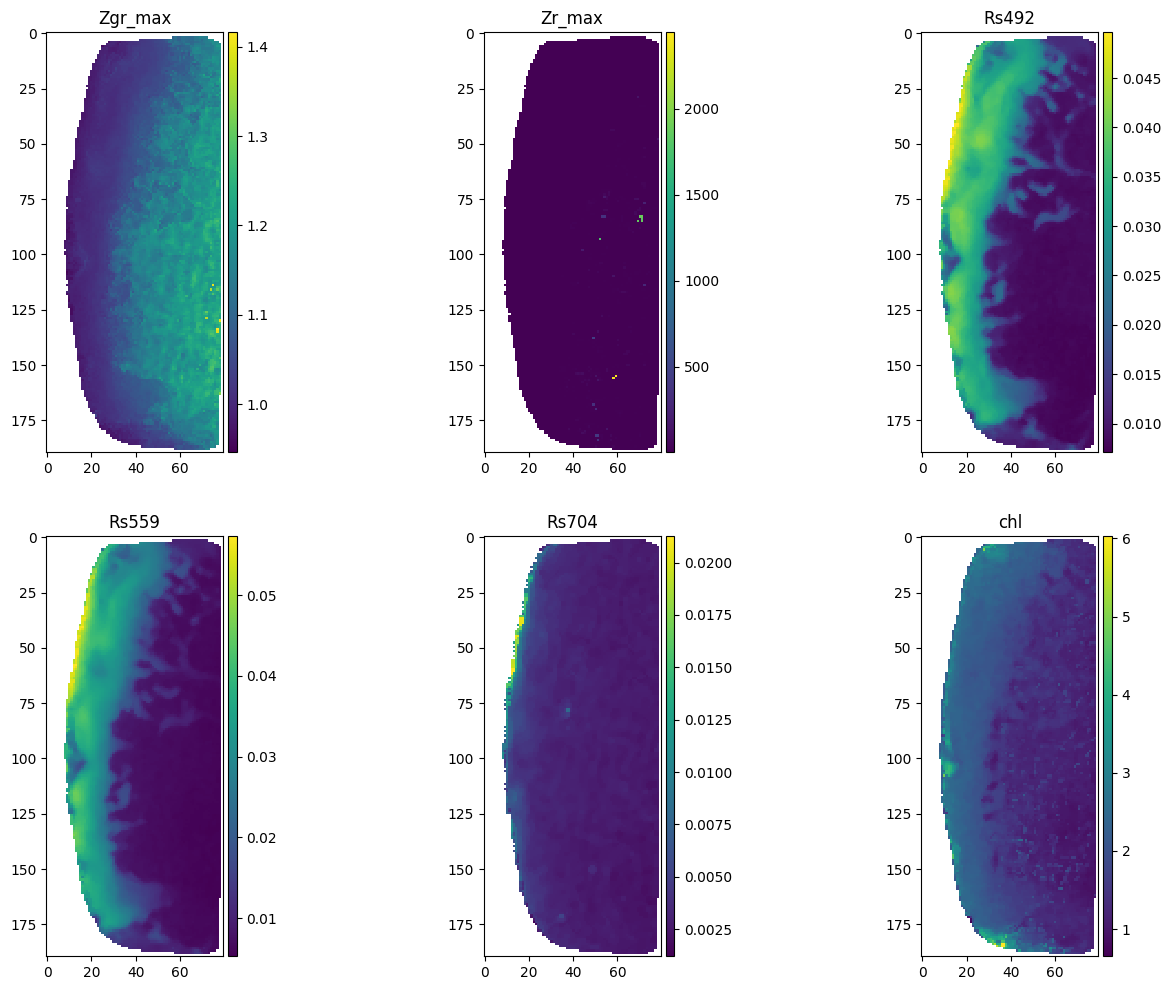

In [5]:
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(231)
im1 = ax1.imshow(Zgr_max, interpolation='nearest', cmap='viridis')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('Zgr_max')

ax2 = fig.add_subplot(232)
im2 = ax2.imshow(Zr_max, interpolation='nearest', cmap='viridis')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');
ax2.set_title('Zr_max')

ax3 = fig.add_subplot(233)
im3 = ax3.imshow(Rs492, interpolation='nearest', cmap='viridis')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical');
ax3.set_title('Rs492')

ax4 = fig.add_subplot(234)
im4 = ax4.imshow(Rs559, interpolation='nearest', cmap='viridis')
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical');
ax4.set_title('Rs559')

ax5 = fig.add_subplot(235)
im5 = ax5.imshow(Rs704, interpolation='nearest', cmap='viridis')
divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im5, cax=cax, orientation='vertical');
ax5.set_title('Rs704')

ax6 = fig.add_subplot(236)
im6 = ax6.imshow(chl, interpolation='nearest', cmap='viridis')
divider = make_axes_locatable(ax6)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im6, cax=cax, orientation='vertical');
ax6.set_title('chl')

## train

In [6]:
Zr_max[Zr_max < 0] = np.nan
Zr_max[Zr_max > np.nanpercentile(Zr_max, 98)] = np.nan
Zred_mx = np.ma.masked_invalid(Zr_max)
Zgr_max[Zred_mx.mask] = np.nan

In [7]:
train_df = pd.DataFrame({'bathymetry': -bathymetry.flatten(), 
                         'Rs492': Rs492.flatten(),
                         'Rs559': Rs559.flatten(),
                         'Rs704': Rs704.flatten(),
                         'chl': chl.flatten(),
                         'rt23': Zgr_max.flatten(),
                         'rt24': Zr_max.flatten(),
                        })

train_df.loc[train_df.isnull().any(axis=1), :] = np.nan
train_df = train_df.dropna()

# Obtener los índices de las filas no eliminadas
idx_no_nan = train_df.index

# Crear una matriz 3x3 con valores NaN
mapa = np.full_like(bathymetry, np.nan)

In [8]:
## Normalizar los datos de entrada/input
xdf = train_df[['Rs492', 'Rs559', 'Rs704', 'chl', 
                'rt23', 'rt24']]

x = xdf.values
x_scaler = preprocessing.StandardScaler()
# x_scaler = preprocessing.MinMaxScaler()
x_scaled = x_scaler.fit_transform(x)
x_train = pd.DataFrame(x_scaled)
x_train = x_train.rename({0: 'Rs492', 1: 'Rs559', 2: 'Rs704', 3: 'chl',
                          4: 'rt23', 5: 'rt24'}, axis='columns')

In [9]:
# ## Normalizar la salida/output
# ydf = train_df[['bathymetry']]
# y = ydf.values
# y_scaler = preprocessing.StandardScaler()
# # y_scaler = preprocessing.MinMaxScaler()
# y_scaled = y_scaler.fit_transform(y)
# y_train = pd.DataFrame(y_scaled)
# y_train = y_train.rename({0: 'bathymetry'}, axis='columns')

y_train = (train_df[['bathymetry']]).values

In [10]:
param_distributions_gb = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2]
}

gb = GradientBoostingRegressor(random_state=42)
random_search_gb = RandomizedSearchCV(estimator=gb, param_distributions=param_distributions_gb, n_iter=100, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
random_search_gb.fit(x_train, y_train)
best_params_gb = random_search_gb.best_params_
best_params_gb

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

{'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 10,
 'learning_rate': 0.05}

In [11]:
# Fit regression model
gbregr = GradientBoostingRegressor(**best_params_gb)
gbregr.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_split=5,
                          n_estimators=50)

## test

In [12]:
region = 'CalaMillor'
year = '2018'
main_path = os.path.join(config.data_path(), 'bathymetries', region, year)

Num of bands: 1
Shape: (191, 75)
CRS: EPSG:32631
{'N': 39.603276863053686, 'W': 3.3843451835046254, 'S': 39.58612860972737, 'E': 3.392867787365727}


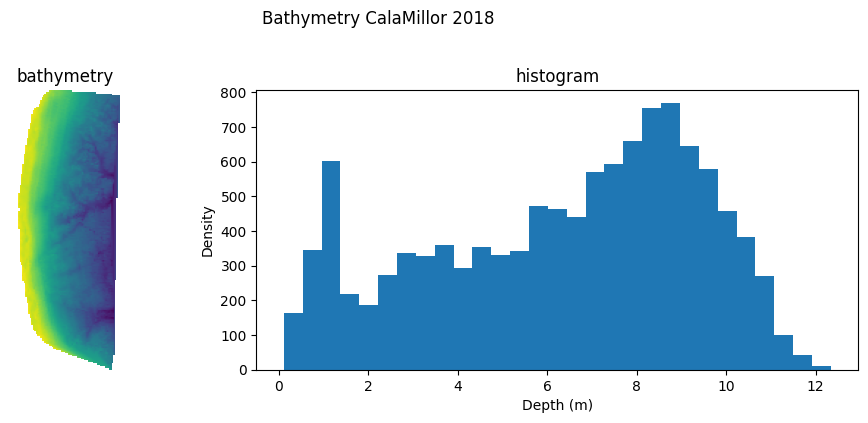

In [13]:
## In-situ bathymetry
file = '{}_Insitu_bathymetry_EPSG32631_{}.tif'.format(region, year)
bathymetry, BBox, crs = geo_utils.load_geotiff(os.path.join(main_path, file))
# bathymetry[bathymetry < -5] = np.nan
mx = np.ma.masked_invalid(bathymetry)

## transform coordinates
new_ul = geo_utils.transform_coordinates(BBox[0], inputEPSG=crs, outputEPSG=4326)
new_lr = geo_utils.transform_coordinates(BBox[1], inputEPSG=crs, outputEPSG=4326)

# ROI
roi_coord = {'N': new_ul[0], 'W': new_ul[1], 'S': new_lr[0], 'E': new_lr[1]}
print(roi_coord)

# plot it
fig=plt.figure(figsize=(12,8))

ax1 = plt.subplot2grid((2,3),(0,0))
ax1.imshow(bathymetry)
ax1.set_title('bathymetry')
ax1.axis('off')

ax2 = plt.subplot2grid((2,3),(0,1), colspan=3)
ax2.hist((-bathymetry).flatten(), bins='auto')
ax2.set_title('histogram')
ax2.set_xlabel('Depth (m)')
ax2.set_ylabel('Density')

fig.suptitle('Bathymetry {} {}'.format(region, year))
plt.show()

In [14]:
tiles = config.get_tiles(region, year)
Zgr_max, Zr_max, Rs492, Rs559, Rs704, chl, coord = SDB.ML_WQproxies(tiles, roi_coord)

Zgr_max[mx.mask] = np.nan
Zr_max[mx.mask] = np.nan
Rs492[mx.mask] = np.nan
Rs559[mx.mask] = np.nan
Rs704[mx.mask] = np.nan
chl[mx.mask] = np.nan

Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20181002T103021_N0206_R108_T31SED_20181002T142247
Selected pixel region: xmin=3301, ymin=1624, xmax=3375, ymax=1814:
Image size: width=75 x height=191
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20181002T103021_N0206_R108_T31SED_20181002T142247
Selected pixel region: xmin=3301, ymin=1624, xmax=3375, ymax=1814:
Image size: width=75 x height=191
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20181025T104121_N0206_R008_T31SED_20181025T125227
Selected pixel region: xmin=3301, ymin=1624, xmax=3375, ymax=1814:
Image size: width=75 x height=191
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2B_MSIL1C_20180917T103019_N0206_R108_T31SED_20180917T161011
Selected pixel region: xmin=3301, ymin=1624, xmax=3375, ymax=1814:
Image size: width=75 x height=191
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2B_MSIL1C_20180920T104019_N0206_R008_T31SED_20180920T143638
Selected pixel region: xmin=3301, ymin=1624, xmax=3375, ymax=1814:
Imag

/home/wq_sat/wq_sat/bathymetry/SDB.py:50: RuntimeWarning: All-NaN slice encountered
  Zgr_max = np.nanmax(Zgreen, axis=2)
/home/wq_sat/wq_sat/bathymetry/SDB.py:51: RuntimeWarning: All-NaN slice encountered
  Zr_max = np.nanmax(Zred, axis=2)
/home/wq_sat/wq_sat/bathymetry/SDB.py:52: RuntimeWarning: All-NaN slice encountered
  Rs492_max = np.nanmax(Rs492, axis=2)
/home/wq_sat/wq_sat/bathymetry/SDB.py:53: RuntimeWarning: All-NaN slice encountered
  Rs559_max = np.nanmax(Rs559, axis=2)
/home/wq_sat/wq_sat/bathymetry/SDB.py:54: RuntimeWarning: All-NaN slice encountered
  Rs704_max = np.nanmax(Rs704, axis=2)
/home/wq_sat/wq_sat/bathymetry/SDB.py:55: RuntimeWarning: All-NaN slice encountered
  chl_max = np.nanmax(chl, axis=2)


In [15]:
Zr_max[Zr_max < 0] = np.nan
Zr_max[Zr_max > np.nanpercentile(Zr_max, 98)] = np.nan
Zred_mx = np.ma.masked_invalid(Zr_max)
Zgr_max[Zred_mx.mask] = np.nan

In [16]:
test_df = pd.DataFrame({'bathymetry': -bathymetry.flatten(), 
                        'Rs492': Rs492.flatten(),
                        'Rs559': Rs559.flatten(),
                        'Rs704': Rs704.flatten(),
                        'chl': chl.flatten(),
                        'rt23': Zgr_max.flatten(),
                        'rt24': Zr_max.flatten(),
                        })

test_df.loc[test_df.isnull().any(axis=1), :] = np.nan
test_df = test_df.dropna()

# Obtener los índices de las filas no eliminadas
idx_no_nan = test_df.index

# Crear una matriz 3x3 con valores NaN
mapa = np.full_like(bathymetry, np.nan)

In [17]:
## Normalizar los datos de entrada/input
xdf = test_df[['Rs492', 'Rs559', 'Rs704', 'chl', 
               'rt23', 'rt24']]

x = xdf.values
x_scaled = x_scaler.transform(x)
x_test = pd.DataFrame(x_scaled)
x_test = x_test.rename({0: 'Rs492', 1: 'Rs559', 2: 'Rs704', 3: 'chl',
                        4: 'rt23', 5: 'rt24'}, axis='columns')

In [18]:
# Predict
result = gbregr.predict(x_test)

# inverse normalization
# y_pred = y_scaler.inverse_transform(result.reshape(-1, 1))
y_pred = result.reshape(-1, 1)

# recover original bathymetry
y_true = (test_df[['bathymetry']].values).reshape(-1, 1)

/tmp/ipykernel_18118/3657175115.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot([0,15], [0,15], 'k-', c='r', alpha=0.75, zorder=0)


Text(0.5, 1.0, 'Error')

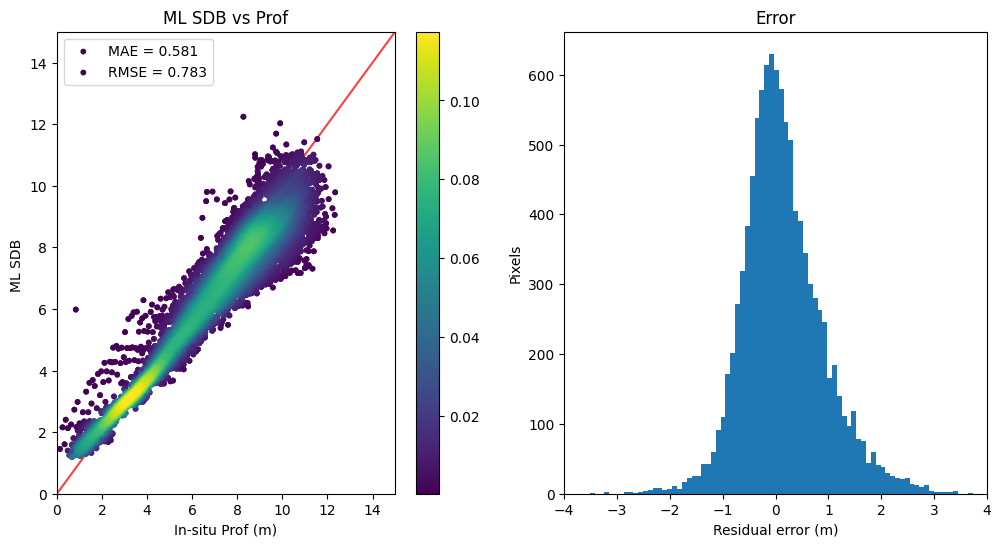

In [19]:
SDB_diff = y_true - (y_pred + 0.3)

mx = np.ma.masked_invalid(SDB_diff)
diff = SDB_diff[~mx.mask]

# Calculate the point density
x = y_true[~mx.mask]
y = y_pred[~mx.mask]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

MAE = np.nanmean(np.abs(diff))
RMSE = np.sqrt(np.nanmean(diff**2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(x, y, c=z, s=10, label=f'MAE = {MAE:.3f}')
ax_ = axs[0].scatter(x, y, c=z, s=10, label=f'RMSE = {RMSE:.3f}')
plt.colorbar(ax_)
axs[0].plot([0,15], [0,15], 'k-', c='r', alpha=0.75, zorder=0)
axs[0].set_xlabel("In-situ Prof (m)")
axs[0].set_xlim(0,15)
axs[0].set_ylabel("ML SDB ")
axs[0].set_ylim(0,15)
axs[0].legend()
axs[0].set_title("ML SDB vs Prof")

axs[1].hist(SDB_diff.flatten(), bins=100)
axs[1].set_xlim(-4,4)
axs[1].set_xlabel("Residual error (m)")
axs[1].set_ylabel("Pixels")
axs[1].set_title("Error")

In [20]:
# Asignar los valores predichos en las ubicaciones originales en la matriz_resultado
mapa.ravel()[idx_no_nan] = result
# mapa = y_scaler.inverse_transform(mapa)
ml_sdb = data_utils.interpolation2d(mapa)

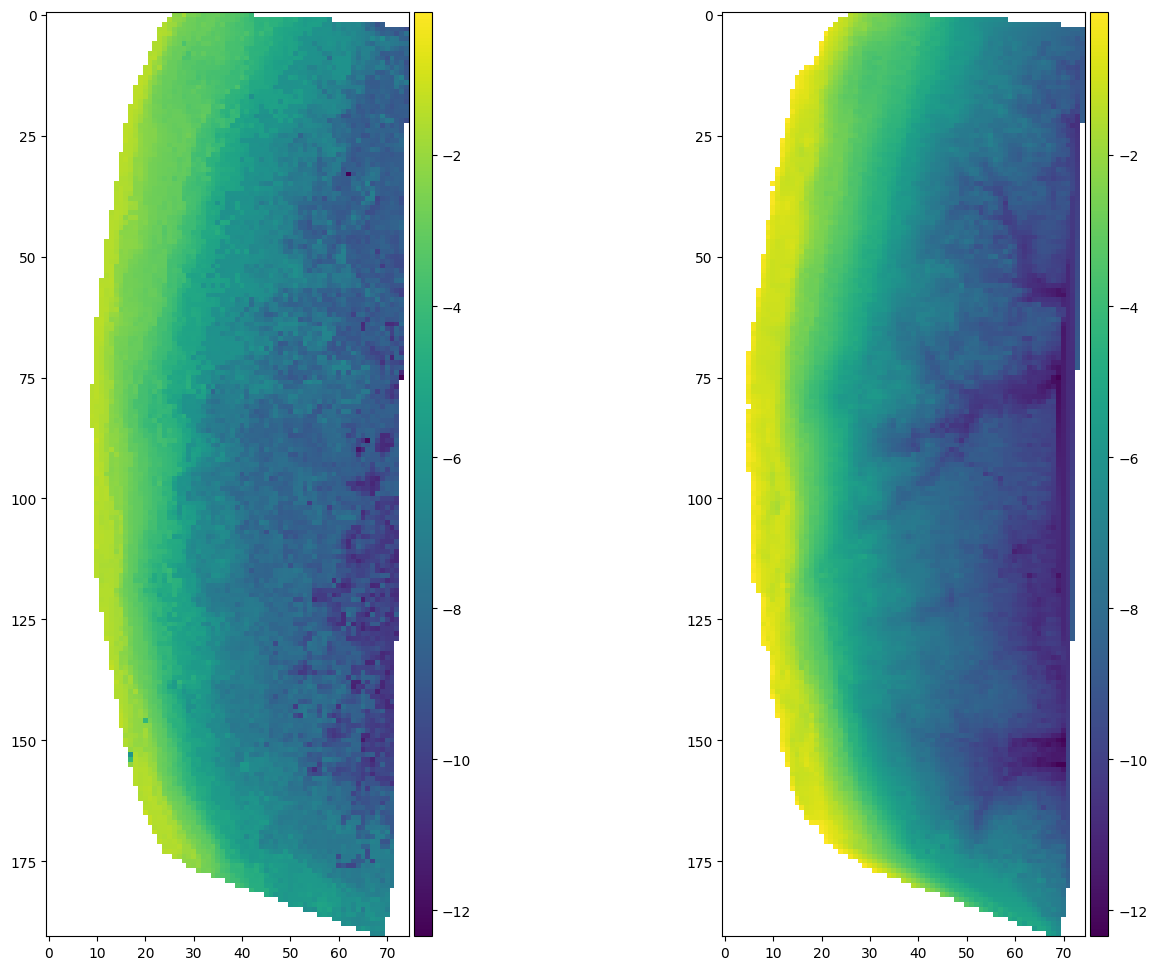

In [21]:
fig = plt.figure(figsize=(16, 12))

sdb_min = np.nanmin(bathymetry)
sdb_max = np.nanmax(bathymetry)

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(-ml_sdb, interpolation='nearest', cmap='viridis', vmin=sdb_min, vmax=sdb_max)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(bathymetry, interpolation='nearest', cmap='viridis', vmin=sdb_min, vmax=sdb_max)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

## Ibiza

In [89]:
roi_coord = {'N': 38.89112, 'W': 1.16445, 'S': 38.85693, 'E': 1.23046}
tile = 'S2B_MSIL1C_20230226T103919_N0509_R008_T31SCD_20230226T141935'

tile_path = config.acolite_path(tile)
data_bands, coord = sentinel2.Rs_acolite(tile_path, roi_coord)

## pZgrenn & pZred
Zgreen = np.log(3140*data_bands['B2'])/np.log(3140*data_bands['B3'])
Zred = np.log(3140*data_bands['B2'])/np.log(3140*data_bands['B4'])

Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2B_MSIL1C_20230226T103919_N0509_R008_T31SCD_20230226T141935
Selected pixel region: xmin=4196, ymin=9489, xmax=4538, ymax=9706:
Image size: width=343 x height=218


In [90]:
Zred[Zred < 0] = np.nan
Zred[Zred > np.nanpercentile(Zred, 98)] = np.nan
Zred_mx = np.ma.masked_invalid(Zred)
Zgreen[Zred_mx.mask] = np.nan

In [91]:
test_df = pd.DataFrame({'Rs492': data_bands['B2'].flatten(),
                        'Rs559': data_bands['B3'].flatten(),
                        'Rs704': data_bands['B5'].flatten(),
                        'chl': data_bands['chl'].flatten(),
                        'rt23': Zgreen.flatten(),
                        'rt24': Zred.flatten(),
                        })

test_df.loc[test_df.isnull().any(axis=1), :] = np.nan
test_df = test_df.dropna()

# Obtener los índices de las filas no eliminadas
idx_no_nan = test_df.index

# Crear una matriz 3x3 con valores NaN
mapa = np.full_like(data_bands['B2'], np.nan)

In [92]:
## Normalizar los datos de entrada/input
xdf = test_df[['Rs492', 'Rs559', 'Rs704', 'chl', 
               'rt23', 'rt24']]

x = xdf.values
x_scaled = x_scaler.transform(x)
x_test = pd.DataFrame(x_scaled)
x_test = x_test.rename({0: 'Rs492', 1: 'Rs559', 2: 'Rs704', 3: 'chl',
                        4: 'rt23', 5: 'rt24'}, axis='columns')

In [93]:
# Predict
result = gbregr.predict(x_test)

# Asignar los valores predichos en las ubicaciones originales en la matriz_resultado
mapa.ravel()[idx_no_nan] = result
# mapa = y_scaler.inverse_transform(mapa)
ml_sdb = data_utils.interpolation2d(mapa)

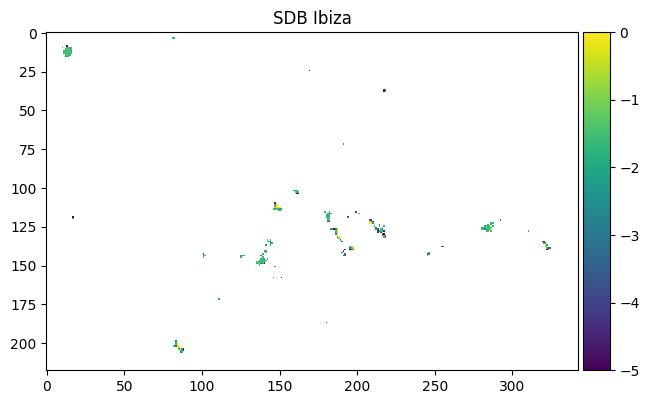

In [94]:
ml_sdb[ml_sdb > 5] = np.nan

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(-ml_sdb, interpolation='nearest', cmap='viridis', vmin=-5, vmax=0)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('SDB Ibiza')
plt.show()

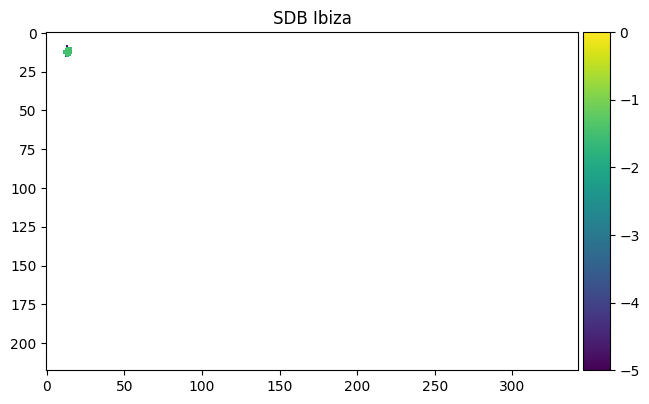

In [95]:
ml_sdb = data_utils.filter_noise(ml_sdb ,n_thresh = 30)

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(-ml_sdb, interpolation='nearest', cmap='viridis', vmin=-5, vmax=0)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('SDB Ibiza')
plt.show()

Loading /home/wqsat_data/Sentinel-2/S2MSI1C/S2B_MSIL1C_20230226T103919_N0509_R008_T31SCD_20230226T141935.SAFE
Selected UTM Zone: UTM 31N
Selected pixel region: xmin=4194, ymin=9486, xmax=4535, ymax=9701:
Image size: width=342 x height=216


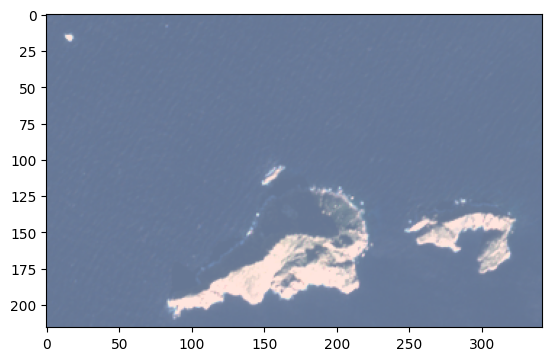

In [88]:
# roi_coord = {'N': 38.881, 'W': 1.178, 'S': 38.862, 'E': 1.218}
# tile_path = config.safe_path(tile)
# rgb_bands, tile_coord = sentinel2.L1C_bands(tile_path, roi_coord)
# rgb_im = plot_utils.get_RGBimage(rgb_bands['B4'], rgb_bands['B3'], rgb_bands['B2'])

# plt.imshow(rgb_im)

Loading /home/wqsat_data/Sentinel-2/S2MSI1C/S2B_MSIL1C_20230226T103919_N0509_R008_T31SCD_20230226T141935.SAFE
Selected UTM Zone: UTM 31N
Selected pixel region: xmin=4194, ymin=9486, xmax=4535, ymax=9701:
Image size: width=342 x height=216


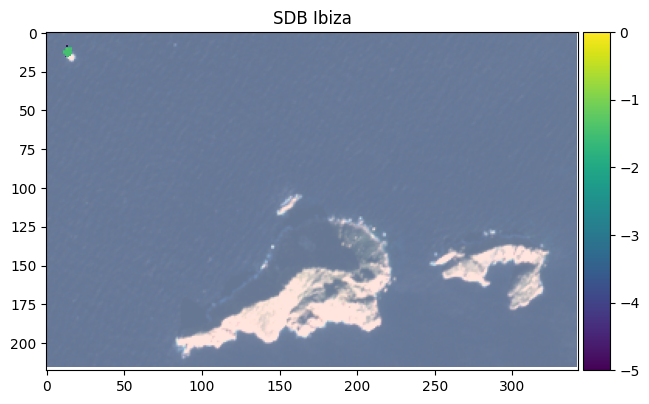

In [96]:
tile_path = config.safe_path(tile)
rgb_bands, tile_coord = sentinel2.L1C_bands(tile_path, roi_coord)
rgb_im = plot_utils.get_RGBimage(rgb_bands['B4'], rgb_bands['B3'], rgb_bands['B2'])

fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(121)
ax1.imshow(rgb_im)
im1 = ax1.imshow(-ml_sdb, interpolation='nearest', cmap='viridis', vmin=-5, vmax=0)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('SDB Ibiza')

# ax1.add_patch(
#      patches.Rectangle(
#         (110, 110),
#         330,
#         220,
#         edgecolor = 'k',
#         fill=False      
#      ) )

plt.show()

In [97]:
# SDB geotiff
path = '/home/wq_sat/notebooks/bathymetries/ML_SDB/'
file = 'MLsdb_ibiza_zoom.tif'
geo_utils.save_gdal(os.path.join(path, file), 
                    np.expand_dims(-ml_sdb, axis=-1), 
                    ['SDB'], 
                    coord['geotransform'], 
                    coord['geoprojection'])

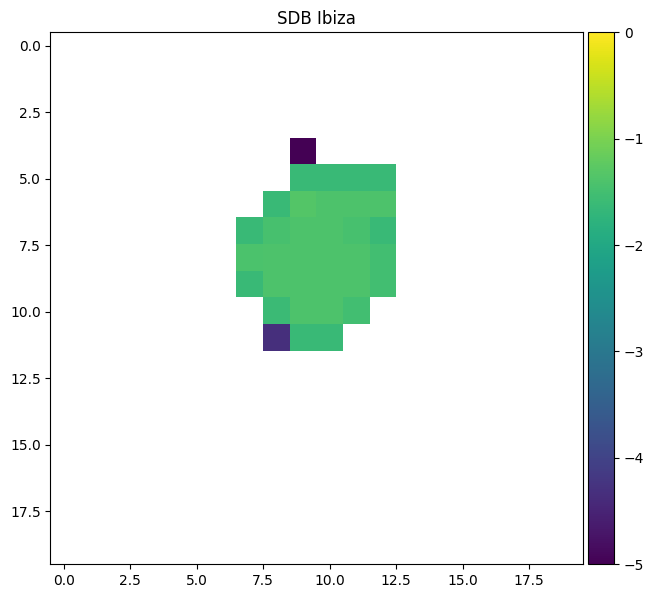

In [48]:
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(-ml_sdb[120:140,120:140], interpolation='nearest', cmap='viridis', vmin=-5, vmax=0)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('SDB Ibiza')
plt.show()

In [50]:
print(np.nanmax(-ml_sdb[120:140,120:140]) + 0.5)

-0.8347517251968384
